# PS reconstruction, Gaussian beam

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend
from phase_space_reconstruction.virtual.scans import run_3d_scan, run_t_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_3d_scan, train_3d_scan_parallel_gpus

from bmadx.distgen_utils import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

## Create synthetic ground truth beam

In [2]:
# create synthetic ground truth beam from base and transform yaml files
#yaml_dir = os.path.join('data', 'yaml_files')
save_dir = os.path.join('data', 'gaussian_beam', 'low_E_spread')
p0c = 43.36e6 # reference momentum in eV/c
#gt_beam = create_beam(
#    base_yaml = os.path.join(yaml_dir, 'gaussian.yaml'),
#    transforms_yaml = os.path.join(yaml_dir, 'transforms-linear-no-z-E-corr.yaml'), 
#    p0c = p0c,
#    n_particle = 1_000_000,
#    save_as = os.path.join(save_dir, 'gaussian_beam.pt')
#)
gt_beam = torch.load(os.path.join(save_dir, 'gaussian_beam.pt'))

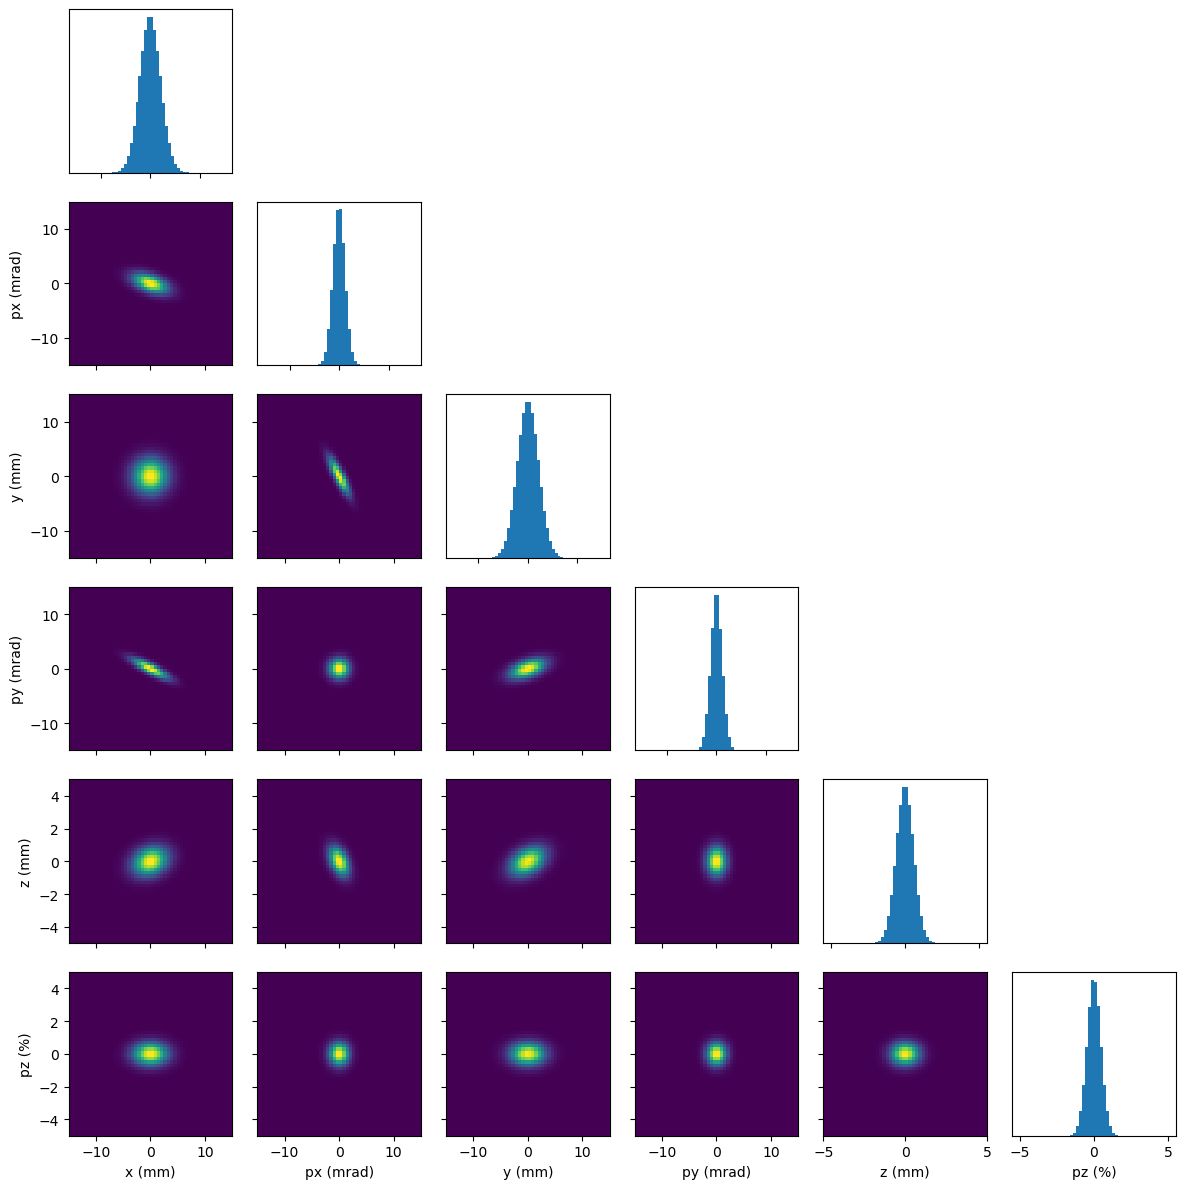

In [3]:
#plot gt beam
lims = np.array([[-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-15e-3, 15e-3],
                 [-5e-3, 5e-3],
                 [-5e-2, 5e-2]]) 
fig, ax = plot_projections(
    gt_beam.numpy_particles(),
    custom_lims = lims,
    background = 0
)
plt.show()

## Define diagnostics lattice parameters

In [4]:
# triplet params obtained from triplet-opt.ipynb
k1 =    10.986991
k2 =   -24.674763
k3 =    26.907939

In [5]:
# diagnostic beamline:
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
lattice.elements[0].K1.data = torch.tensor(k1)
lattice.elements[2].K1.data = torch.tensor(k2)
lattice.elements[4].K1.data = torch.tensor(k3)

# Scan over quad strength, tdc on/off and dipole on/off
scan_ids = [6, 8, 10] 
n_ks = 5
ks = torch.linspace(-10, 10, n_ks) # quad ks
vs = torch.tensor([0, 1e7]) # TDC off/on
gs = torch.tensor([2.22e-16, 20.0*PI/180.0/0.365]) # dipole off/on
train_params = torch.stack(torch.meshgrid(ks, vs, gs, indexing='ij'))
print(train_params.shape)
print(train_params.unsqueeze(-1).shape)

# create diagnostic screen: 
bins = torch.linspace(-25, 25, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

torch.Size([3, 5, 2, 2])
torch.Size([3, 5, 2, 2, 1])


## Complete 3D scan training data

In [6]:
# generate and save train and test datasets
train_dset_3d_scan = run_3d_scan(
    gt_beam, 
    lattice,
    screen, 
    ks, vs, gs,
    ids = scan_ids,
    )

print(train_dset_3d_scan.params.shape)
print(train_dset_3d_scan.images.shape)

torch.Size([20, 3, 1])
torch.Size([20, 1, 200, 200])


torch.Size([200, 200])


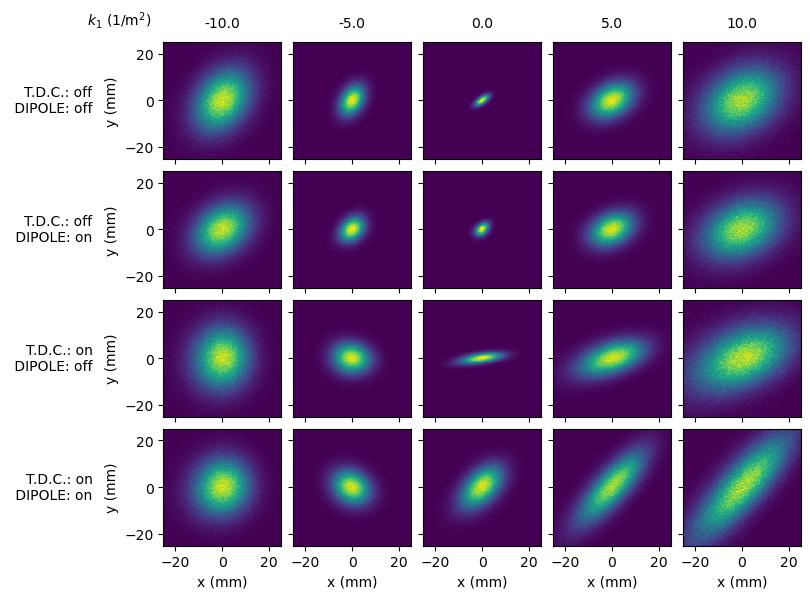

In [12]:
from phase_space_reconstruction.visualization import plot_3d_scan_data
fig, ax = plot_3d_scan_data(train_dset_3d_scan, bins, publication_size=True)
for ele in ax[-1]:
    ele.set_xticks([-20,0,20])
for ele in ax[:,0]:
    ele.set_yticks([-20,0,20])

fig.savefig("gaussian_data.png",dpi=300)
fig.savefig("gaussian_data.svg")
plt.show()

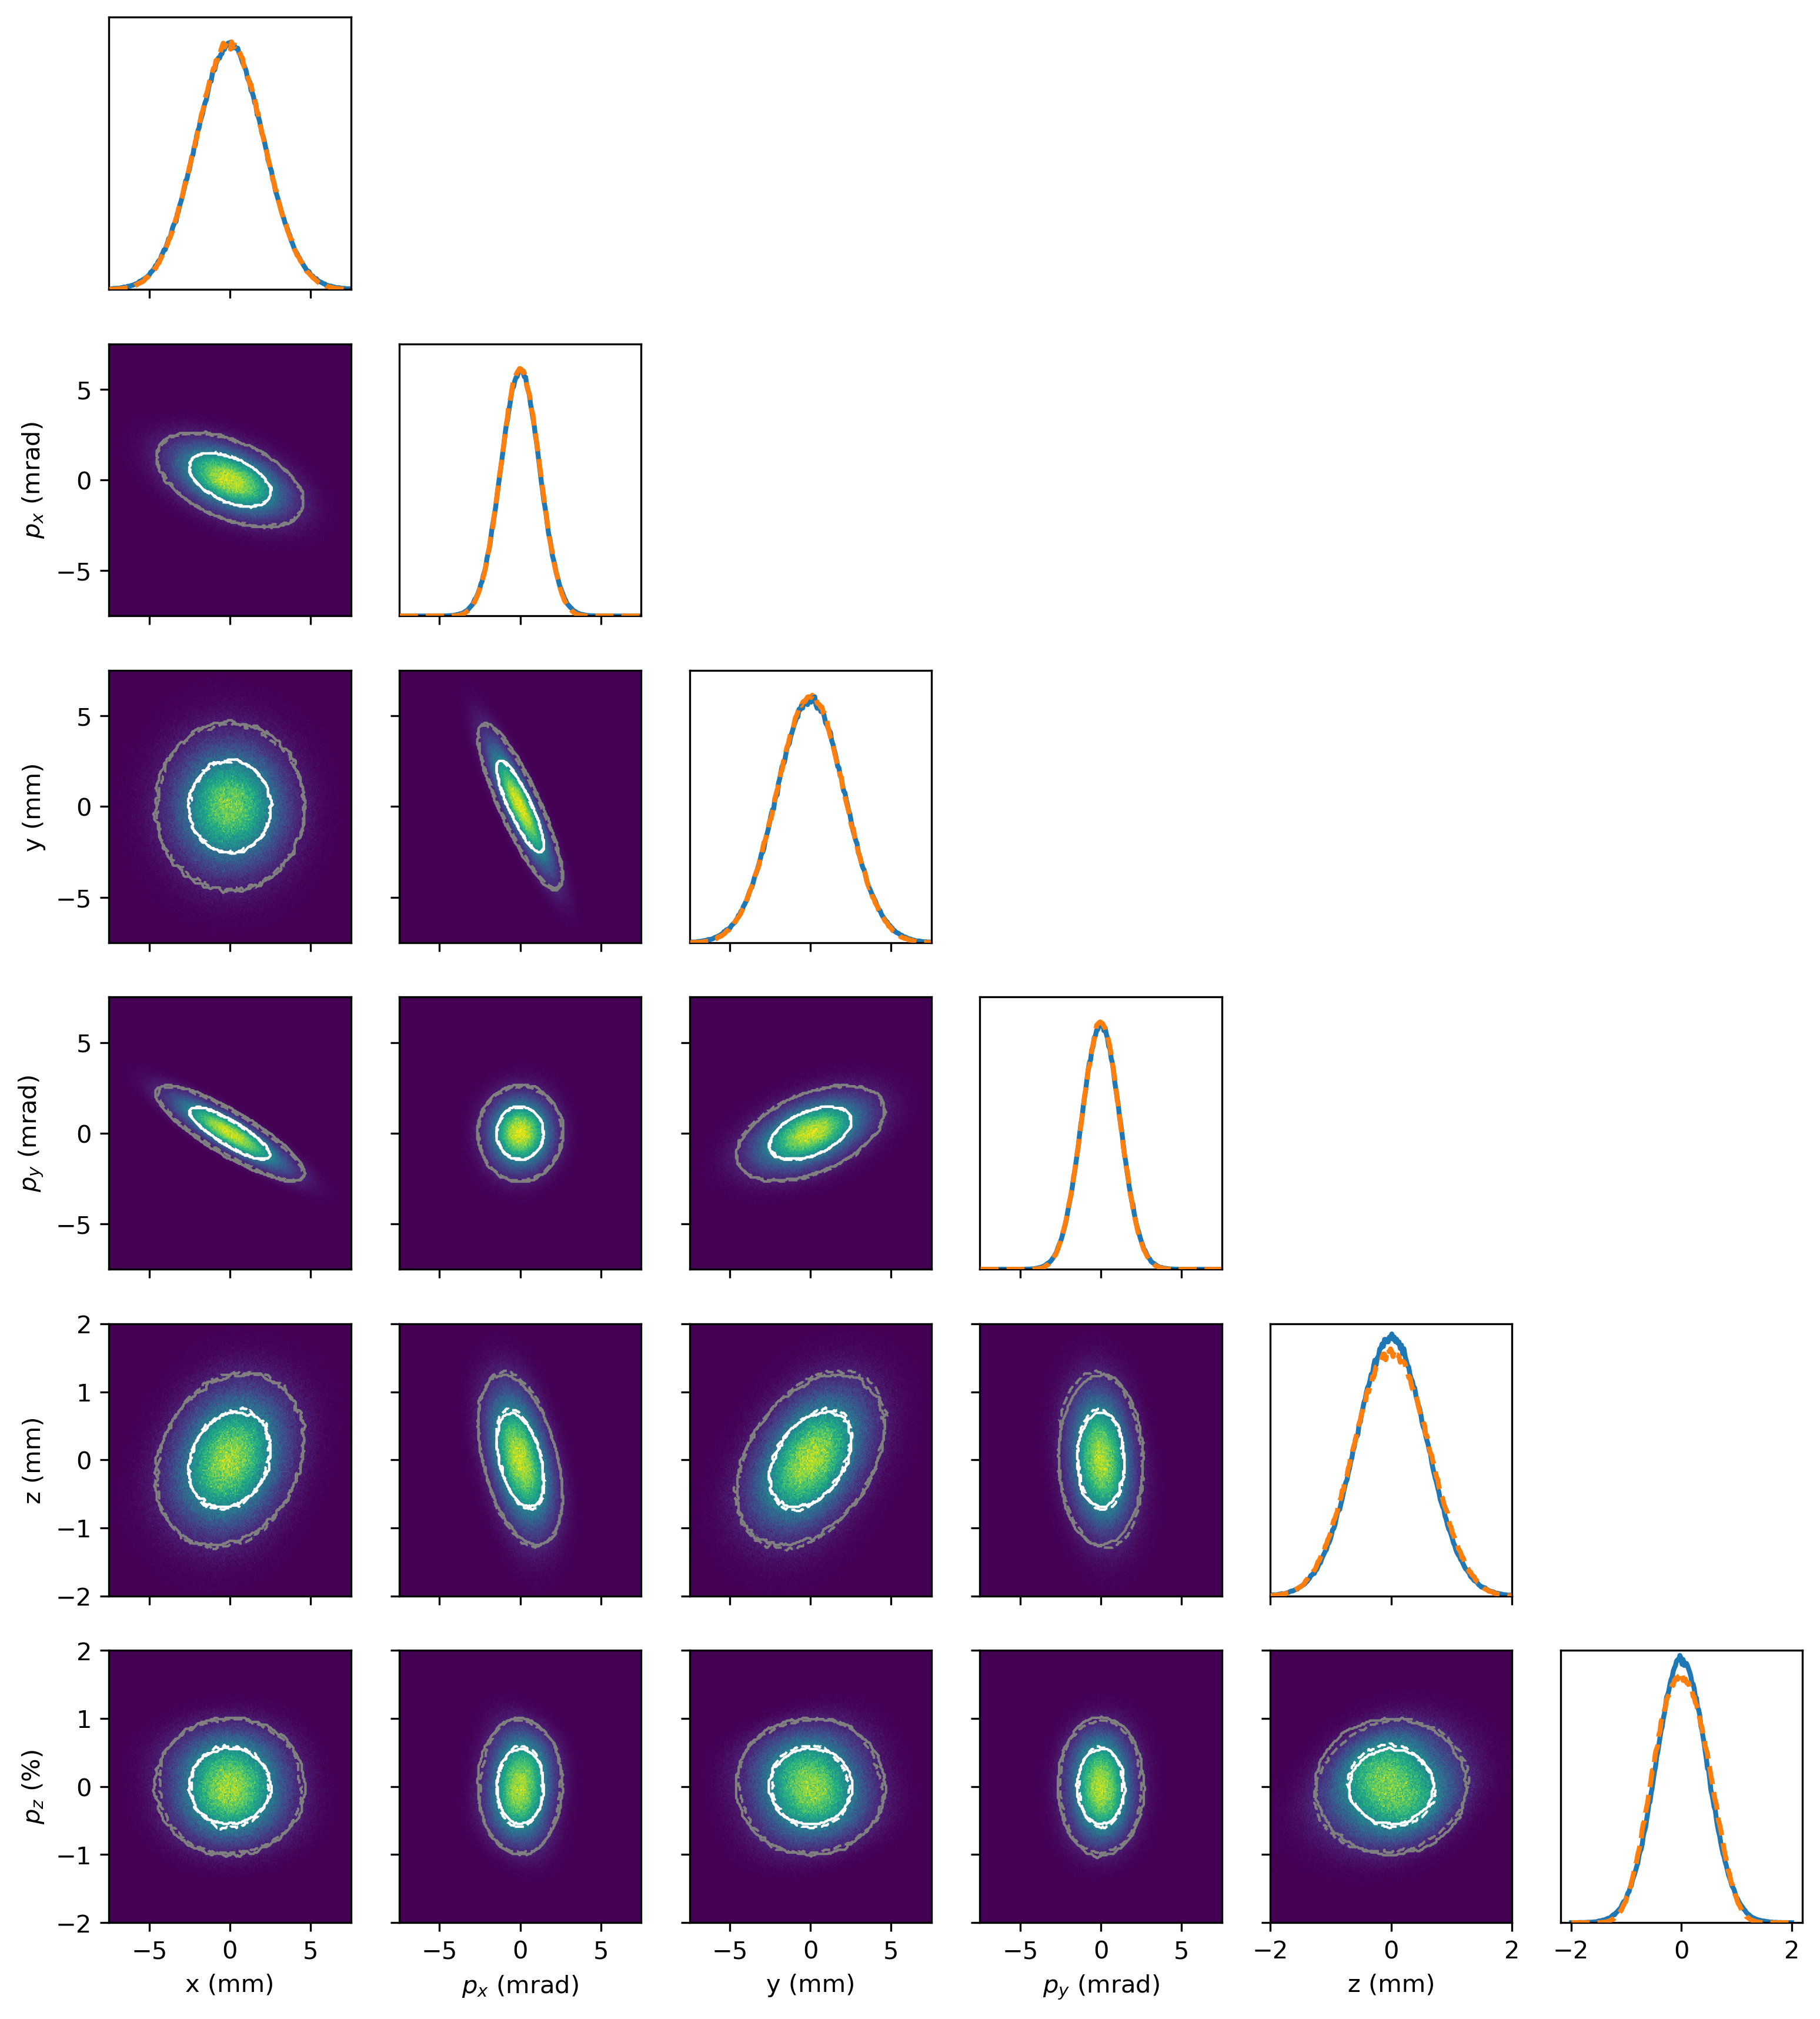

In [14]:
import torch
from stats import plot_projections_with_contours, show_cov_stats
import os

lims = np.array([[-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-15, 15],
                 [-4, 4],
                 [-4, 4]])*0.5 

recn_dist = torch.load(os.path.join(save_dir, 'dist_3000.pt'))
recn_dist.data = recn_dist.data
fig,ax = plot_projections_with_contours(
    recn_dist,
    gt_beam,
    n_bins=200,
    contour_percentiles = [50, 90],
    custom_lims=lims,
    contour_smoothing=0.25,
)

In [15]:
from stats import plot_projections_with_contours,show_cov_stats,get_cov,plot_cov_sigmas
frac = 0.9
cov_gt_frac = get_cov(gt_beam.numpy_particles(), beam_fraction=frac)
cov_reconstruction_frac = get_cov(recn_dist.numpy_particles(), beam_fraction=frac)

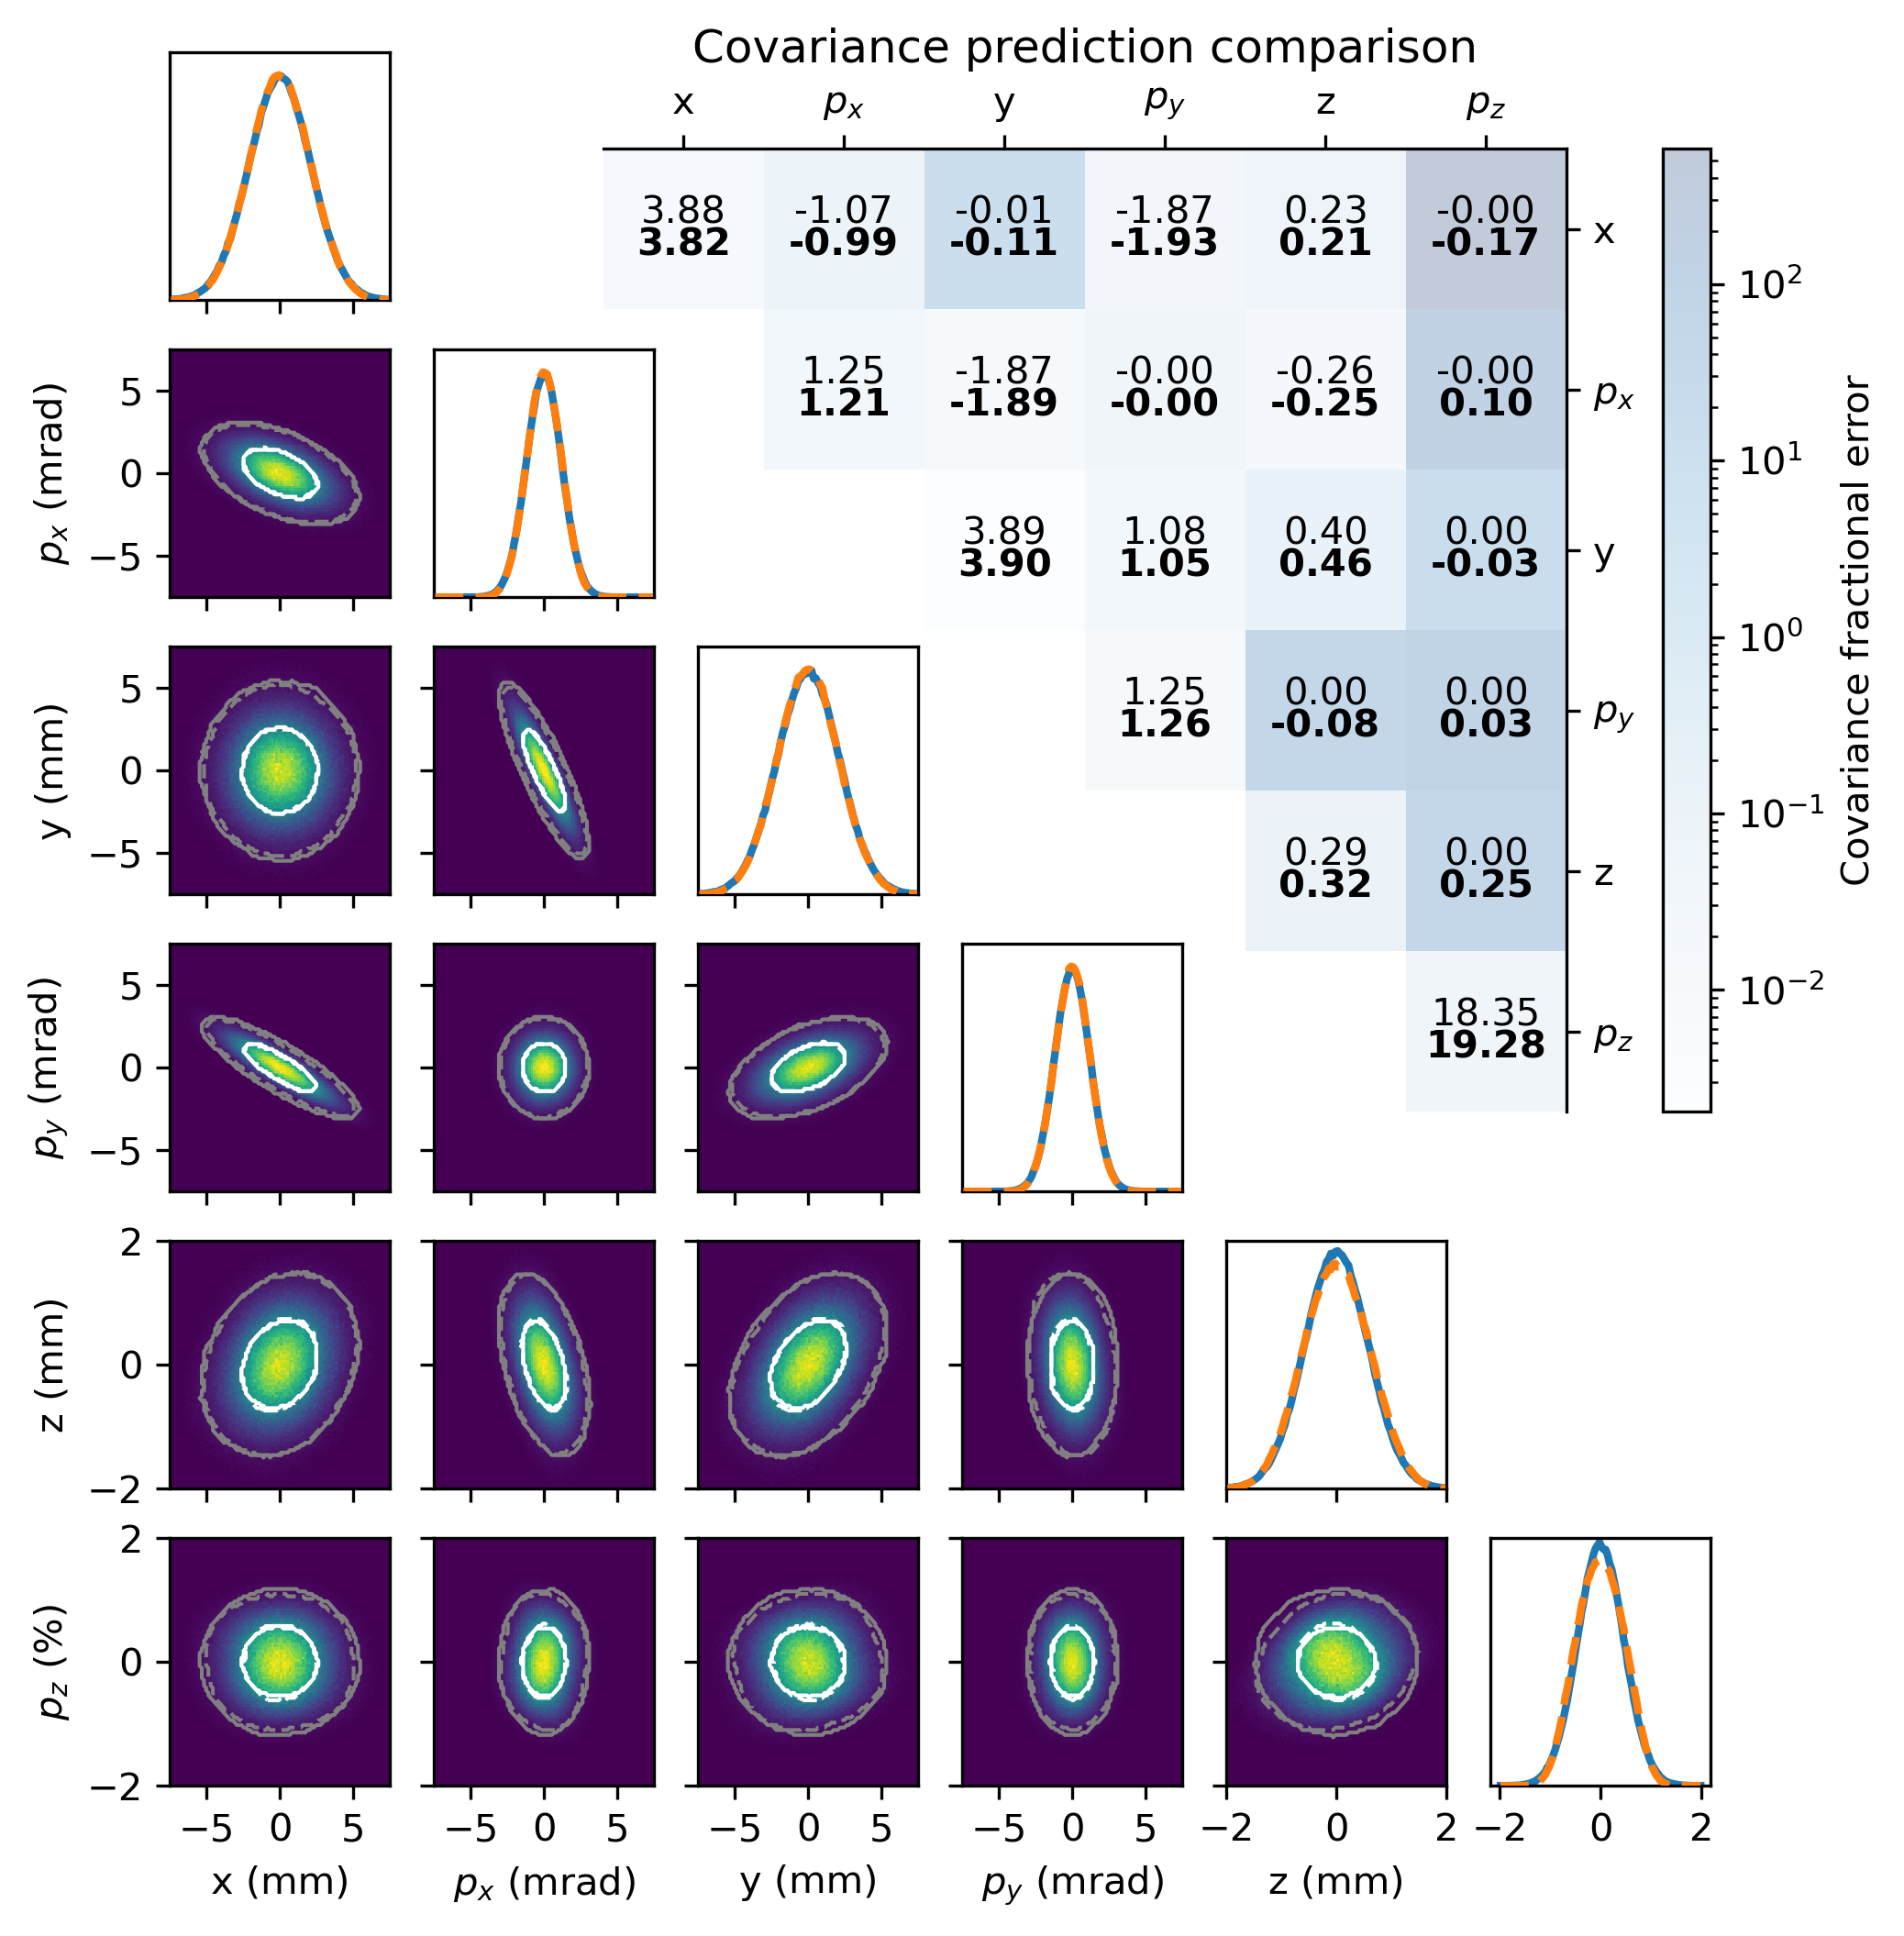

In [16]:
from stats import plot_prab_figure

fig = plot_prab_figure(
    torch.load(os.path.join(save_dir, 'dist_3000.pt')),
    gt_beam,
    n_bins=100,
    contour_percentiles = [50, 95],
    custom_lims=lims,
)
fig.savefig("gaussian_reconstruction.png",dpi=300)
fig.savefig("gaussian_reconstruction.svg")

In [11]:
torch.cuda.empty_cache()